In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
db_url = os.getenv('db_url')
engine = create_engine(db_url)

In [3]:
energy_df = pd.read_sql_table('energy', con=engine)
energy_df

,date_time,generation_biomass,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_other_renewable,generation_solar,generation_wind_onshore,total_renewable_generation,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,total_load_forecast,total_load_actual,price_day_ahead,price_actual,price_difference,price_lag_1d,price_lag_7d,price_lag_30d
0,2015-01-01 00:00:00,447.0,863.0,1051.0,1899.0,73.0,49.0,6378.0,10760.0,17,6436,26118,25385.0,50.10,65.41,15.31,65.41,65.41,65.41
1,2015-01-01 01:00:00,449.0,920.0,1009.0,1658.0,71.0,50.0,5890.0,10047.0,16,5856,24934,24382.0,48.10,64.92,16.82,65.41,65.41,65.41
2,2015-01-01 02:00:00,448.0,1164.0,973.0,1371.0,73.0,50.0,5461.0,9540.0,8,5454,23515,22734.0,47.33,64.48,17.15,64.92,65.41,65.41
3,2015-01-01 03:00:00,438.0,1503.0,949.0,779.0,75.0,50.0,5238.0,9032.0,2,5151,22642,21286.0,42.27,59.32,17.05,64.48,65.41,65.41
4,2015-01-01 04:00:00,428.0,1826.0,953.0,720.0,74.0,42.0,4935.0,8978.0,9,4861,21785,20264.0,38.41,56.04,17.63,59.32,65.41,65.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35055,2018-12-31 19:00:00,297.0,1.0,1135.0,4836.0,95.0,85.0,3113.0,9562.0,96,3253,30619,30653.0,68.85,77.02,8.17,77.61,72.42,69.40
35056,2018-12-31 20:00:00,296.0,1.0,1172.0,3931.0,95.0,33.0,3288.0,8816.0,51,3353,29932,29735.0,68.40,76.16,7.76,77.02,71.80,69.90
35057,2018-12-31 21:00:00,292.0,50.0,1148.0,2831.0,94.0,31.0,3503.0,7949.0,36,3404,27903,28071.0,66.88,74.30,7.42,76.16,71.95,66.97
35058,2018-12-31 22:00:00,293.0,108.0,1128.0,2068.0,93.0,31.0,3586.0,7307.0,29,3273,25450,25801.0,63.93,69.89,5.96,74.30,70.85,65.48


In [4]:
weather_df = pd.read_sql_table('weather', con=engine)
weather_df

,date_time,city_name,avg_temp,wind_speed,humidity
0,2015-01-01 00:00:00,Valencia,270.475,1,77
1,2015-01-01 01:00:00,Valencia,270.475,1,77
2,2015-01-01 02:00:00,Valencia,269.686,0,78
3,2015-01-01 03:00:00,Valencia,269.686,0,78
4,2015-01-01 04:00:00,Valencia,269.686,0,78
...,...,...,...,...,...
175295,2018-12-31 19:00:00,Seville,287.650,3,54
175296,2018-12-31 20:00:00,Seville,285.650,3,62
175297,2018-12-31 21:00:00,Seville,285.150,4,58
175298,2018-12-31 22:00:00,Seville,284.150,4,57


In [5]:
weather_df['city_name'].value_counts()

Valencia     35060
Madrid       35060
Bilbao       35060
Barcelona    35060
Seville      35060
Name: city_name, dtype: int64

In [6]:
weather_data_grouped = weather_df.groupby('date_time').agg({
    'avg_temp': ['mean', 'max', 'std'],
    'wind_speed': ['mean', 'max', 'std'],
    'humidity': ['mean', 'max', 'std']
}).reset_index()
weather_data_grouped.columns = [
    'date_time', 'avg_temp', 'max_temp', 'std_temp',        
    'avg_wind_speed', 'max_wind_speed', 'std_wind_speed', 
    'avg_humidity', 'max_humidity', 'std_humidity'
]

In [7]:
weather_data_grouped

,date_time,avg_temp,max_temp,std_temp,avg_wind_speed,max_wind_speed,std_wind_speed,avg_humidity,max_humidity,std_humidity
0,2015-01-01 00:00:00,272.491463,281.625,5.545111,2.0,7,2.828427,82.4,100,15.678010
1,2015-01-01 01:00:00,272.512700,281.625,5.531730,2.0,7,2.828427,82.4,100,15.678010
2,2015-01-01 02:00:00,272.099137,281.286,5.857526,2.4,7,2.792848,82.0,100,15.890249
3,2015-01-01 03:00:00,272.089469,281.286,5.863439,2.4,7,2.792848,82.0,100,15.890249
4,2015-01-01 04:00:00,272.145900,281.286,5.829980,2.4,7,2.792848,82.0,100,15.890249
...,...,...,...,...,...,...,...,...,...,...
35055,2018-12-31 19:00:00,284.450000,287.650,2.413504,1.4,3,1.140175,73.6,93,16.652327
35056,2018-12-31 20:00:00,282.150000,285.650,2.549510,1.8,3,1.095445,68.0,93,15.508062
35057,2018-12-31 21:00:00,280.850000,285.150,3.232646,2.6,4,1.516575,71.4,100,19.165072
35058,2018-12-31 22:00:00,279.750000,284.150,3.189828,2.8,5,1.643168,70.0,93,17.464249


In [8]:
df_joined = weather_data_grouped.set_index('date_time').join(energy_df.set_index('date_time'))
df_joined

,avg_temp,max_temp,std_temp,avg_wind_speed,max_wind_speed,std_wind_speed,avg_humidity,max_humidity,std_humidity,generation_biomass,...,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,total_load_forecast,total_load_actual,price_day_ahead,price_actual,price_difference,price_lag_1d,price_lag_7d,price_lag_30d
date_time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,272.491463,281.625,5.545111,2.0,7,2.828427,82.4,100,15.678010,447.0,...,17,6436,26118,25385.0,50.10,65.41,15.31,65.41,65.41,65.41
2015-01-01 01:00:00,272.512700,281.625,5.531730,2.0,7,2.828427,82.4,100,15.678010,449.0,...,16,5856,24934,24382.0,48.10,64.92,16.82,65.41,65.41,65.41
2015-01-01 02:00:00,272.099137,281.286,5.857526,2.4,7,2.792848,82.0,100,15.890249,448.0,...,8,5454,23515,22734.0,47.33,64.48,17.15,64.92,65.41,65.41
2015-01-01 03:00:00,272.089469,281.286,5.863439,2.4,7,2.792848,82.0,100,15.890249,438.0,...,2,5151,22642,21286.0,42.27,59.32,17.05,64.48,65.41,65.41
2015-01-01 04:00:00,272.145900,281.286,5.829980,2.4,7,2.792848,82.0,100,15.890249,428.0,...,9,4861,21785,20264.0,38.41,56.04,17.63,59.32,65.41,65.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,284.450000,287.650,2.413504,1.4,3,1.140175,73.6,93,16.652327,297.0,...,96,3253,30619,30653.0,68.85,77.02,8.17,77.61,72.42,69.40
2018-12-31 20:00:00,282.150000,285.650,2.549510,1.8,3,1.095445,68.0,93,15.508062,296.0,...,51,3353,29932,29735.0,68.40,76.16,7.76,77.02,71.80,69.90
2018-12-31 21:00:00,280.850000,285.150,3.232646,2.6,4,1.516575,71.4,100,19.165072,292.0,...,36,3404,27903,28071.0,66.88,74.30,7.42,76.16,71.95,66.97


In [9]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35060 entries, 2015-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 27 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   avg_temp                                     35060 non-null  float64
 1   max_temp                                     35060 non-null  float64
 2   std_temp                                     35060 non-null  float64
 3   avg_wind_speed                               35060 non-null  float64
 4   max_wind_speed                               35060 non-null  int64  
 5   std_wind_speed                               35060 non-null  float64
 6   avg_humidity                                 35060 non-null  float64
 7   max_humidity                                 35060 non-null  int64  
 8   std_humidity                                 35060 non-null  float64
 9   generation_biomass                   

In [10]:
class Scaler():
    def __init__(self):
        self.scaler_X = MinMaxScaler()
        self.scaler_Y = MinMaxScaler()

    def fit_transform(self, X=None, y=None):
        if X is not None:
            X.columns = X.columns.astype(str)
            X = self.scaler_X.fit_transform(X)
        if y is not None:
            y = y.values.reshape(-1, 1)
            y = self.scaler_Y.fit_transform(y)
        return X, y

    def transform(self, X=None, y=None):
        if X is not None:
            X.columns = X.columns.astype(str)
            X = self.scaler_X.transform(X)
        if y is not None:
            y = y.values.reshape(-1, 1)
            y = self.scaler_Y.transform(y)
        return X, y

    def inverse_transform(self, X=None, y=None):
        if X is not None:
            X = self.scaler_X.inverse_transform(X)
        if y is not None:
            y = self.scaler_Y.inverse_transform(y.reshape(-1, 1))
        return X, y

In [11]:
class EnergyDataset(Dataset):
    def __init__(self, data, target, sequence_length=24):
        self.data = data
        self.target = target
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.sequence_length]  # Past `sequence_length` hours
        y = self.target[idx+self.sequence_length]    # Predict next hour price
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [12]:
class LSTMEnergyModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2):
        super(LSTMEnergyModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

In [13]:
class EnergyPricePredictionPipeline():
    def __init__(self, model, sequence_length=24, batch_size=64, epochs=10):
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.epochs = epochs
        self.scaler = Scaler()

    def fit(self, X, y):
        X_scaled, y_scaled = self.scaler.fit_transform(X, y)
        train_size = int(0.8 * len(X_scaled))
        val_size = int(0.2 * len(X_scaled))

        train_dataset = EnergyDataset(X_scaled[:train_size], y_scaled[:train_size], self.sequence_length)
        val_dataset = EnergyDataset(X_scaled[train_size:train_size+val_size], y_scaled[train_size:train_size+val_size], self.sequence_length)
       
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            train_samples = 0

            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                self.optimizer.zero_grad()
                y_pred = self.model(X_batch)
                # loss = self.criterion(y_pred, y_batch.unsqueeze(1))
                loss = self.criterion(y_pred, y_batch.view(-1, 1))
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item() * X_batch.size(0)
                train_samples += X_batch.size(0)

            train_rmse = (train_loss / train_samples) ** 0.5 

            self.model.eval()
            val_loss = 0
            val_samples = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                    y_pred = self.model(X_batch)
                    # loss = self.criterion(y_pred, y_batch.unsqueeze(1))
                    loss = self.criterion(y_pred, y_batch.view(-1, 1))
                    val_loss += loss.item() * X_batch.size(0)
                    val_samples += X_batch.size(0)
        
            val_rmse = (val_loss / val_samples) ** 0.5
        
            print(f"Epoch {epoch+1}/{self.epochs}, Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")
            
    def score(self, X, y):
        X_scaled, y_scaled = self.scaler.transform(X, y)
        test_dataset = EnergyDataset(X_scaled, y_scaled, self.sequence_length)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        self.model.eval()
        test_loss = 0
        test_samples = 0
        actuals = []
        predictions = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                
                y_pred = self.model(X_batch)
                
                _, y_pred_inv = self.scaler.inverse_transform(y = y_pred.cpu().numpy())
                _, y_actual_inv = self.scaler.inverse_transform(y = y_batch.cpu().numpy())

                predictions.extend(y_pred_inv.flatten())
                actuals.extend(y_actual_inv.flatten())
                
                loss = self.criterion(y_pred, y_batch.view(-1, 1))
                test_loss += loss.item() * X_batch.size(0)
                test_samples += X_batch.size(0)
    
        test_rmse = (test_loss / test_samples) ** 0.5
        print(f"Test RMSE: {test_rmse:.4f}")

        return actuals, predictions

    def predict(self, X):
        X_scaled, _ = self.scaler.transform(X=X)
        X_scaled = torch.tensor(X_scaled, dtype=torch.float32)
        self.model.eval()
        prediction = self.model(X_scaled.unsqueeze(0))
        return prediction

In [14]:
train_size = 0.8

train_df, test_df = train_test_split(df_joined, test_size=0.2, random_state=42, shuffle=False)

train_x = train_df.drop(columns=["price_actual"])
train_y = train_df["price_actual"]

test_x = test_df.drop(columns=["price_actual"])
test_y = test_df["price_actual"]

input_size = len(train_x.columns)
model = LSTMEnergyModel(input_size=input_size)

pipeline = EnergyPricePredictionPipeline(model, sequence_length=24, epochs=20)

pipeline.fit(train_x, train_y)

Epoch 1/20, Train RMSE: 0.0900, Validation RMSE: 0.0532
Epoch 2/20, Train RMSE: 0.0429, Validation RMSE: 0.0377
Epoch 3/20, Train RMSE: 0.0335, Validation RMSE: 0.0347
Epoch 4/20, Train RMSE: 0.0288, Validation RMSE: 0.0280
Epoch 5/20, Train RMSE: 0.0262, Validation RMSE: 0.0315
Epoch 6/20, Train RMSE: 0.0252, Validation RMSE: 0.0298
Epoch 7/20, Train RMSE: 0.0246, Validation RMSE: 0.0255
Epoch 8/20, Train RMSE: 0.0238, Validation RMSE: 0.0250
Epoch 9/20, Train RMSE: 0.0242, Validation RMSE: 0.0294
Epoch 10/20, Train RMSE: 0.0238, Validation RMSE: 0.0285
Epoch 11/20, Train RMSE: 0.0240, Validation RMSE: 0.0268
Epoch 12/20, Train RMSE: 0.0242, Validation RMSE: 0.0258
Epoch 13/20, Train RMSE: 0.0237, Validation RMSE: 0.0250
Epoch 14/20, Train RMSE: 0.0237, Validation RMSE: 0.0246
Epoch 15/20, Train RMSE: 0.0234, Validation RMSE: 0.0246
Epoch 16/20, Train RMSE: 0.0233, Validation RMSE: 0.0255
Epoch 17/20, Train RMSE: 0.0235, Validation RMSE: 0.0275
Epoch 18/20, Train RMSE: 0.0232, Validat

In [15]:
actuals, predictions = pipeline.score(test_x, test_y)

Test RMSE: 0.0202


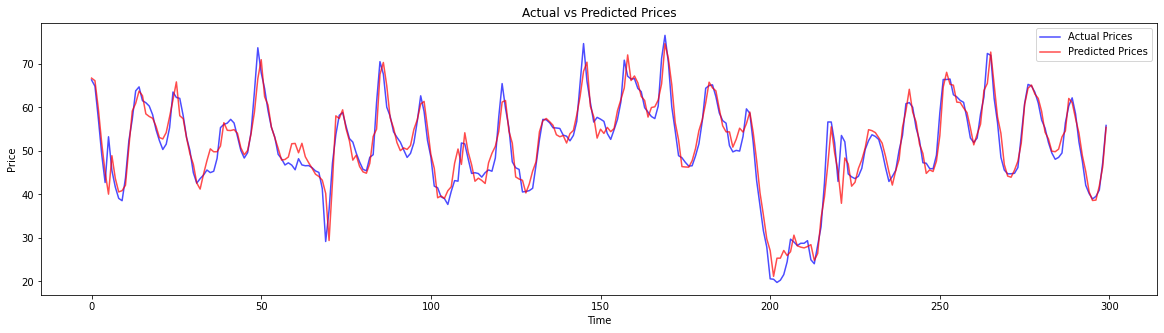

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(actuals[:300], label="Actual Prices", color='blue', alpha=0.7)
plt.plot(predictions[:300], label="Predicted Prices", color='red', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.show()

In [17]:
prediction = pipeline.predict(test_x[0:24])

In [18]:
prediction.item()

0.5339627265930176

In [19]:
import pickle

In [20]:
with open("..\models\pipline.pkl","wb") as f:
    pickle.dump(pipeline, f)

In [21]:
torch.save(model, '..\models\LSTM_model.pth')